# Мэтчинг товаров

## Описание задачи

Задача заключается в разработке модели, позволяющей определить пять товаров, наиболее близких к запрашиваемому. 

Качество модели определяется метрикой accuracy@5 (также top5 accuracy). Модель для каждого запроса выдает 5 наиболее близких результатов. Если запрашиваемый результат попал в список из пяти ответов, то метрика положительна. Необходимо добиться наиболее высокого значения метрики. 

**Описание данных**

1) base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

2) train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

3) validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

4) validation_answer.csv - правильные ответы к предыдущему файлу

Объекты в train.csv и validation.csv это запросы, индексы объектов соответственно обозначены как запросы. В train.csv объекты размечены (то есть им найдены соответствия товаров из base). В validation.csv такой разметки нет. Но это разметка хранится в validation_answer.csv

Base.csv - список товаров, индексы которого обозначают сам товар. 

По большому счету нужно разработать алгоритм, который будет наиболее точно подбирать 5 товаров из base, соответствующих запросу. 


## Установка пакетов и импорты

In [1]:
pip install annoy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install missingno --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install ydata-profiling --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install faiss

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import faiss
from ydata_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import accuracy_score

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.cluster import KMeans

from annoy import AnnoyIndex


Зададим размеры для всех графиков

In [6]:
plt.rcParams["figure.figsize"] = (15,15)

## Загрузка и оценка данных

При загрузке данных будем первую столбец использовать как индекс

Анализ признаков будем делать с помощью ydata_profiling, но чтобы его не делать каждый раз, я **закомменчу, чтобы не тратить время при перезапуске тетрадки**

### BASE

In [7]:
data_base = pd.read_csv('./data/base.csv',index_col=0)

In [8]:
data_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


Посмотрим на данные через profile_report, чтобы оценить распределения данных. Судить о признаках можно только таким образом, ожидая, что они будут распределены равномерно. Если нет, то такие признаки в будущем возможно придется удалить

**Комментарий:**
Использование msno и profile_report я закомментил для всех таблиц, чтобы не захламлять тетрадку. В конце оставил только выводы

In [9]:
#msno.bar(data_base)


In [10]:
#data_base.profile_report(minimal=True)

### TRAIN

In [11]:
data_train = pd.read_csv('./data/train.csv',index_col=0)

In [12]:
data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [13]:
#msno.bar(data_train)

In [14]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

In [15]:
data_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,...,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,...,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,...,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,...,-101.504830,19.774804,-178.929470,-71.745018,66.560655,-14.144571,31.685548,100.589324,-1074.464888,-76.478591
50%,-85.273695,7.652854,-42.830246,-146.067445,112.260100,-73.364420,-511.837758,22.278989,123.087540,125.963340,...,-80.859640,36.711365,-151.576985,14.072663,67.813585,23.441363,72.880192,115.236635,-808.801696,-48.700929
75%,-67.330810,10.981191,-17.713690,-132.277745,143.760830,-53.699612,-201.116578,65.899595,127.541802,169.701005,...,-60.492451,53.919520,-124.436974,100.011024,69.058750,59.941065,114.469224,129.791085,-357.087323,-20.487869
max,14.585236,28.917845,128.108460,-60.751625,301.363600,51.849710,109.625188,288.171840,149.356200,392.827150,...,47.733450,145.667130,11.907364,185.095137,74.779884,266.493320,319.867520,201.761260,98.768233,126.191790


По `Describe` с таким количеством признаков сложно что-то говорить, учитывая, что непонятно что каждый из признаков означает

Файл с тренировочными данными (в нашем случае это data_train) содержит на один столбец больше, чем data_base. 
Это столбец с таргетом

In [16]:
#data_train.profile_report(minimal=True)

Сразу разделим train на признаки и таргет

In [17]:
train_target = data_train['Target']
train_features = data_train.drop('Target', axis=1)

In [18]:
train_target.head()

Id
0-query     675816-base
1-query     366656-base
2-query    1447819-base
3-query    1472602-base
4-query     717819-base
Name: Target, dtype: object

In [19]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,-68.770600,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351


### VALIDATION

In [20]:
data_validation = pd.read_csv('./data/validation.csv', index_col=0)

In [21]:
data_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [22]:
#data_validation.profile_report(minimal=True)

### VALIDATION ANSWER

In [23]:
validation_answer = pd.read_csv('./data/validation_answer.csv', index_col=0)

In [24]:
validation_answer

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base
...,...
199995-query,967418-base
199996-query,1344948-base
199997-query,1690782-base


### Анализ распределений 

Во-первых, пропусков нигде нет

1) Поскольку BASE содержит TRAIN и VALIDATION, то распределения каждого признака имеют идентичный характер.

2) Большинство признаков распределено по нормальному закону

3) Признаки 6, 21, 25, 33, 44, 59, 65 и 70 распределены отличным от нормального образом. В признаках 59 и 65 распределние равномерное, а в остальных из указанных единичные выбросы.

4) На указанные признаки следует обратить внимание (удалил их позже)

## Масштабирование признаков

Масштабирование признаков будем делать сначала мин макс скейлером, который приводит все значения к диапазоне [0,1]
Обучать скейлер будем на BASE

Выберем наилучший скейлер (StandardScaler), остальные закомментим. 

Скейлер выбирал, прогоняя модели. Результат на StandardScaler был лучше. 

### Minmax scaler

In [25]:
# minmax_scaler = MinMaxScaler()
# minmax_scaler.fit(data_base)

In [26]:
# data_base_scaled = minmax_scaler.transform(data_base)
# train_features_scaled = minmax_scaler.transform(train_features)
# data_validation_scaled = minmax_scaler.transform(data_validation);

In [27]:
# data_base_scaled = pd.DataFrame(data_base_scaled, index=data_base.index)
# train_features_scaled = pd.DataFrame(train_features_scaled, index=data_train.index)
# data_validation_scaled = pd.DataFrame(data_validation_scaled, index=data_validation.index)

### Standard Scaler

In [28]:
standard_scaler = StandardScaler()
standard_scaler.fit(data_base)

StandardScaler()

In [29]:
data_base_scaled = standard_scaler.transform(data_base)
train_features_scaled = standard_scaler.transform(train_features)
data_validation_scaled = standard_scaler.transform(data_validation);

In [30]:
data_base_scaled = pd.DataFrame(data_base_scaled, index=data_base.index)
train_features_scaled = pd.DataFrame(train_features_scaled, index=data_train.index)
data_validation_scaled = pd.DataFrame(data_validation_scaled, index=data_validation.index)

### Robust Scaler

In [31]:
# robust_scaler = RobustScaler()
# robust_scaler.fit(data_base)

In [32]:
# data_base_scaled = robust_scaler.transform(data_base)
# train_features_scaled = robust_scaler.transform(train_features)
# data_validation_scaled = robust_scaler.transform(data_validation);

In [33]:
# data_base_scaled = pd.DataFrame(data_base_scaled, index=data_base.index)
# train_features_scaled = pd.DataFrame(train_features_scaled, index=data_train.index)
# data_validation_scaled = pd.DataFrame(data_validation_scaled, index=data_validation.index)

### PowerTransformer

In [34]:
# pt_scaler = PowerTransformer()
# pt_scaler.fit(data_base)

In [35]:
# data_base_scaled = pt_scaler.transform(data_base)
# train_features_scaled = pt_scaler.transform(train_features)
# data_validation_scaled = pt_scaler.transform(data_validation);

In [36]:
# data_base_scaled = pd.DataFrame(data_base_scaled, index=data_base.index)
# train_features_scaled = pd.DataFrame(train_features_scaled, index=data_train.index)
# data_validation_scaled = pd.DataFrame(data_validation_scaled, index=data_validation.index)

### Вывод машстабированных данных

In [37]:
data_base_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-1.159216,0.620350,-0.513723,1.398558,2.269043,-1.160385,-0.282884,0.373663,-0.435627,0.884544,...,1.189049,0.190524,0.073589,-0.894789,-2.262493,-0.510438,0.293004,-0.014051,1.781420,-0.312329
1-base,2.075715,1.060423,-0.652491,-1.002705,-1.157244,-0.500495,1.130652,-0.871900,-0.623903,1.098487,...,-1.272135,0.270119,-0.073569,-1.097493,0.225102,0.014491,1.711283,0.059848,1.853726,-0.281052
2-base,1.285417,-0.343342,0.397878,0.666228,0.853956,-0.973671,1.637293,0.654489,0.828686,0.619635,...,0.086191,0.440159,-1.269686,1.143739,-1.220546,0.773022,0.099669,0.048521,-0.713847,0.365623
3-base,-0.051852,-0.816047,-1.118829,-1.936660,-0.754014,0.461441,0.033281,-0.840347,-0.259958,0.182763,...,0.274980,-1.372853,0.184217,-0.523936,-0.871349,-0.797073,1.014714,0.090076,-0.713847,-0.601807
4-base,0.541780,-0.314538,2.284450,0.303705,-2.276181,-1.422075,-0.020200,0.386656,-0.238677,-0.191508,...,0.716557,0.808178,-0.110496,0.725544,-0.562342,-0.470720,-0.157210,0.920175,-0.713847,1.152406


In [38]:
train_features_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,-1.459626,...,-0.866975,1.274319,-0.024410,-1.173481,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963
1-query,-0.062146,-0.257159,0.324249,-1.543245,0.204684,-0.419328,1.095696,-1.538329,0.193777,0.246358,...,1.254600,-0.991073,0.075152,-0.159574,0.207972,0.028031,0.244774,0.709459,-0.611690,-0.083491
2-query,1.456328,-0.855696,-1.851792,-1.701553,1.700433,0.750504,1.543015,-0.791080,0.328335,1.352615,...,0.886224,1.548929,-0.348054,0.687136,-0.978114,-0.092956,2.240614,0.300576,-0.713847,0.604677
3-query,1.543467,0.203199,-1.833235,1.291201,-0.359536,-1.322073,-1.409605,0.916179,0.050167,1.834418,...,0.573141,0.388351,0.227494,0.806859,-2.007464,1.491032,0.133987,0.128028,-0.713847,0.668019
4-query,0.265046,1.284537,-0.370748,-0.021041,-1.169187,1.977993,0.261015,0.399148,0.355099,-0.326947,...,0.336621,0.406133,-1.001615,-1.331745,-0.474647,0.341715,0.043401,-1.090276,-0.713847,0.638160


In [39]:
data_validation_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,...,0.115241,0.676228,0.275453,0.453766,0.817488,0.693550,0.597167,-0.020121,-0.777845,-1.659674
100001-query,1.304502,0.950910,0.033969,0.615646,0.067603,-0.657373,-1.352459,0.679613,0.540216,-1.107069,...,-0.013756,-0.142350,-0.334949,-0.980522,1.631021,-1.617587,0.360549,0.369533,0.142436,0.545701
100002-query,0.886027,-2.434901,0.955216,-1.185496,-0.320843,0.341078,-1.352459,1.045290,1.193478,0.690080,...,-1.831225,0.140946,-0.118026,-1.347979,-0.044550,1.128563,1.021715,1.204944,1.311027,-0.555197
100003-query,-0.524576,1.623911,1.408637,-0.071830,-0.595916,-2.190385,1.659459,-0.613543,-1.359610,-0.764409,...,0.058666,0.373992,0.540055,-1.217473,1.695934,0.000596,0.949135,1.307485,-0.000064,-0.996489
100004-query,0.269032,-1.704743,0.739119,-1.221980,1.168059,1.550401,1.568739,0.218922,0.821217,-0.347213,...,-1.469227,0.427148,0.498123,-0.004204,1.549868,-0.148400,1.297723,-0.654827,-0.966634,-1.856774


### Корреляция

Посмотрим на корреляцию признаков. Возьмем срез из 20000 записей в train. 
Чтобы не захламлять тетрадку, корреляцию закомментил. 

**Вывод по корреляции**: признаки практически не коррелируют между собой. Максимальная корреляция составила около 0.4 и лишь для единиц признаков. В основном корреляция близка к 0

In [40]:
# train_features_slice = train_features[ : 20000]

In [41]:
# train_features_slice

In [42]:
# %%time 
# phik_overview = train_features.phik_matrix()

In [43]:
# %%time
# plot_correlation_matrix(phik_overview.values, 
#                         x_labels=phik_overview.columns, 
#                         y_labels=phik_overview.index, 
#                         vmin=0, vmax=1, color_map="Greens",
#                         top=5,
#                         #title=, 
#                         fontsize_factor=1.5, 
#                         figsize=(30, 30))
# plt.tight_layout()

## FAISS

Для решения задачи воспользуемся библиотекой FAISS. Будем создавать индексы IndexIVFFlat

Прежде, чем решать задачу, удалим признаки с "ненормальным" распределением

In [44]:
data_base_scaled = data_base_scaled.drop([6, 21, 25, 33, 44, 59, 65, 70], axis=1)

In [45]:
train_features_scaled = train_features_scaled.drop([6, 21, 25, 33, 44, 59, 65, 70], axis=1)

In [46]:
data_validation_scaled = data_validation_scaled.drop([6, 21, 25, 33, 44, 59, 65, 70], axis=1)

Посмотрим на train_target

In [47]:
train_target.values.tolist();

Посмотрим на validation_answer

In [48]:
validation_answer['Expected'].values.tolist();

### Определение количества кластеров и nprobe

При создании индекса IndexIVFFlat нужно указать параметр n_cell - количество кластеров, на которое разбивается пространство с товарами. 

Опытным путем выяснили, что чем меньше кластеров, тем медленнее работает модель, что логично, потому что в таком случае вектор-запрос сопоставляется с бОльшим количеством векторов-товаров. 

Здесь я взял параметр n_probe = 1 (то есть количество кластеров, которое проверяется при поиске ближайшего соседа)

Оценивать требуемое количество кластеров n_cell и nprobe (наверно можно это обозначить как опрашиваемое количество кластеров при поиске) будем на уменьшенной выборке (точность будет ниже, но думаю выводы в целом будут работать и на полных выборках)

Для наглядности построим графики

Другие индексы кроме IVFFLat не пробовал

#### Количество кластеров

Посмотрим как меняется метрика accuracy@5 при поиске товаров из base по запросам из validation. 

Для этого циклом переберем количество кластеров от 1 до 1000 с шагом 20. 

In [49]:
%%time


dims = data_base_scaled.shape[1]
acc_val = []
n_cell_list = list(range(1,1001,20))

for n_cell in n_cell_list:
    
    quantizer = faiss.IndexFlatL2(dims)

    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cell)
    
    idx_l2.nprobe = 1

    idx_l2.train(np.ascontiguousarray(data_base_scaled.values[:50000, :]).astype('float32'))
    idx_l2.add(np.ascontiguousarray(data_base_scaled.values[:500000, :]).astype('float32'))

    base_index = {k: v for k, v in enumerate(data_base_scaled.index.to_list())}

    top_count = 5

    vectors_train_5, idx_train_5 = idx_l2.search(np.ascontiguousarray(train_features_scaled.values[:1000, :]).astype('float32'), top_count)

    vectors_valid_5, idx_valid_5 = idx_l2.search(np.ascontiguousarray(data_validation_scaled.values[:1000, :]).astype('float32'), top_count)

    acc_train = 0
    for target, candidates in zip(train_target.values.tolist(), idx_train_5.tolist()):
        acc_train += int(target in [base_index[number] for number in candidates])

    acc_valid = 0
    for target, candidates in zip(validation_answer['Expected'].values.tolist(), idx_valid_5.tolist()):
        acc_valid += int(target in [base_index[number] for number in candidates])
        
    acc_val.append((acc_valid / len(idx_valid_5) * 100))
    
        
#     print('n_cell = ', n_cell)
#     print('probe =', idx_l2.nprobe)
#     print('accuracy train : {}%'.format(acc_train / len(idx_train_5) * 100))
#     print('accuracy valid : {}%'.format(acc_valid / len(idx_valid_5) * 100))
#     print()
    
    

CPU times: user 18min 42s, sys: 1min 17s, total: 19min 59s
Wall time: 2min 40s


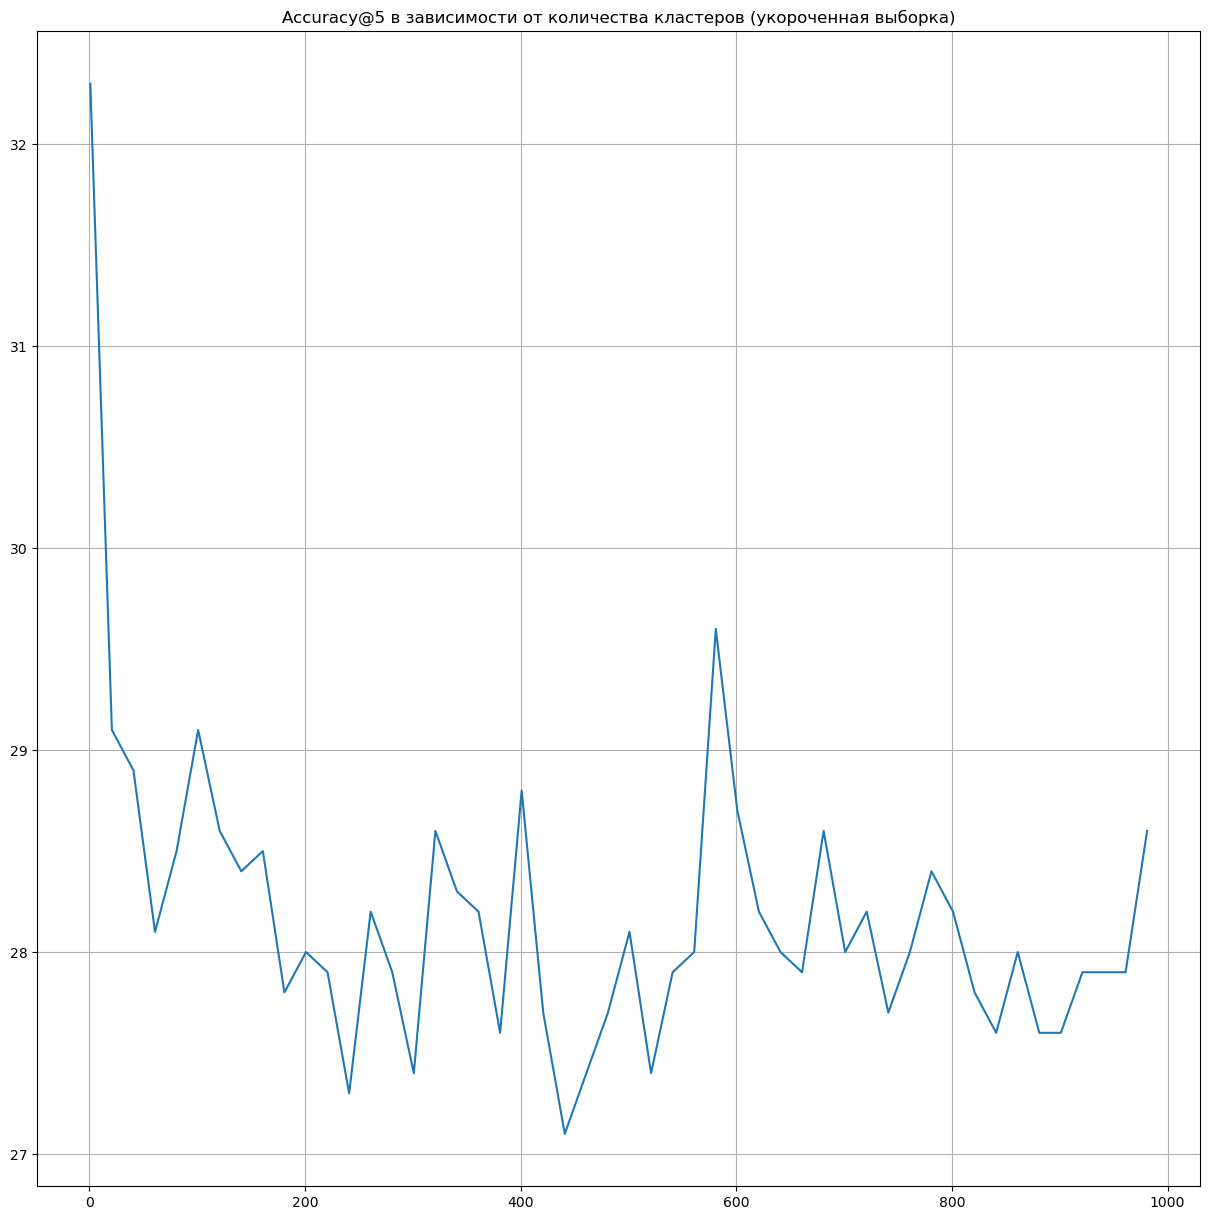

In [50]:
plt.subplot()
plt.plot(n_cell_list, acc_val)
plt.title('Accuracy@5 в зависимости от количества кластеров (укороченная выборка)')
plt.grid()

**Вывод по n_cell** видно, что точность резко снижется до при увеличении количества кластеров от 1 до ~50-60 кластеров. 

Следующий участок можно выделить от 50 до 150 кластеров. 

Далее при увеличении числа кластеров наблюдаются флуктуации на графике. Но визуально можно говорить о том, что эти колебания в диапазоне от 200 до 1000 кластеров происходят вокруг одной точности - 28%. При этом видно выброс по точности при количестве кластеров около 600. Но сложно сказать с чем это связано. 

Малое количество кластеров выбирать можно(до 50), но считать такая модель будет долго из-за перебора большего количества векторов

Судя по графику можно сказать, что оптимальное значение кластеров с точки зрения времени и точности - 100  

#### Nprobe

Возьмем n_cell = 100. И перебером посмотрим как меняется точность на валидационной выборке

Поскольку nprobe это количество опрашиваемых кластеров, то оно очевидно должно составлять некоторую долю от всего количества кластеров. 

Беглый поиск по литературе (http://www.jatit.org/volumes/Vol100No12/6Vol100No12.pdf) показал, что количество оптимальный nprobe лежит близко к 6% от n_cell

тем не менее посмотрим как связана точность с nprobe. nprobe зададим как произведение n_cell на значение от 0.01 до 0.5 с шагом 0.01

In [51]:
%%time

acc_val = []
m_list = (np.array(range(1, 51)) / 100).tolist()
for m in m_list:
    dims = data_base_scaled.shape[1]
    


    n_cell = 100

    quantizer = faiss.IndexFlatL2(dims)

    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cell)

    idx_l2.nprobe = int(n_cell * m)

    idx_l2.train(np.ascontiguousarray(data_base_scaled.values[:50000, :]).astype('float32'))
    idx_l2.add(np.ascontiguousarray(data_base_scaled.values[:500000, :]).astype('float32'))

    base_index = {k: v for k, v in enumerate(data_base_scaled.index.to_list())}

    top_count = 5

    vectors_train_5, idx_train_5 = idx_l2.search(np.ascontiguousarray(train_features_scaled.values[:1000, :]).astype('float32'), top_count)

    vectors_valid_5, idx_valid_5 = idx_l2.search(np.ascontiguousarray(data_validation_scaled.values[:1000, :]).astype('float32'), top_count)

    acc_train = 0
    for target, candidates in zip(train_target.values.tolist(), idx_train_5.tolist()):
        acc_train += int(target in [base_index[number] for number in candidates])

    acc_valid = 0
    for target, candidates in zip(validation_answer['Expected'].values.tolist(), idx_valid_5.tolist()):
        acc_valid += int(target in [base_index[number] for number in candidates])

    acc_val.append((acc_valid / len(idx_valid_5) * 100))


    #     print('n_cell = ', n_cell)
    #     print('probe =', idx_l2.nprobe)
    #     print('accuracy train : {}%'.format(acc_train / len(idx_train_5) * 100))
    #     print('accuracy valid : {}%'.format(acc_valid / len(idx_valid_5) * 100))
    #     print()

    

CPU times: user 15min 49s, sys: 1min 8s, total: 16min 57s
Wall time: 2min 25s


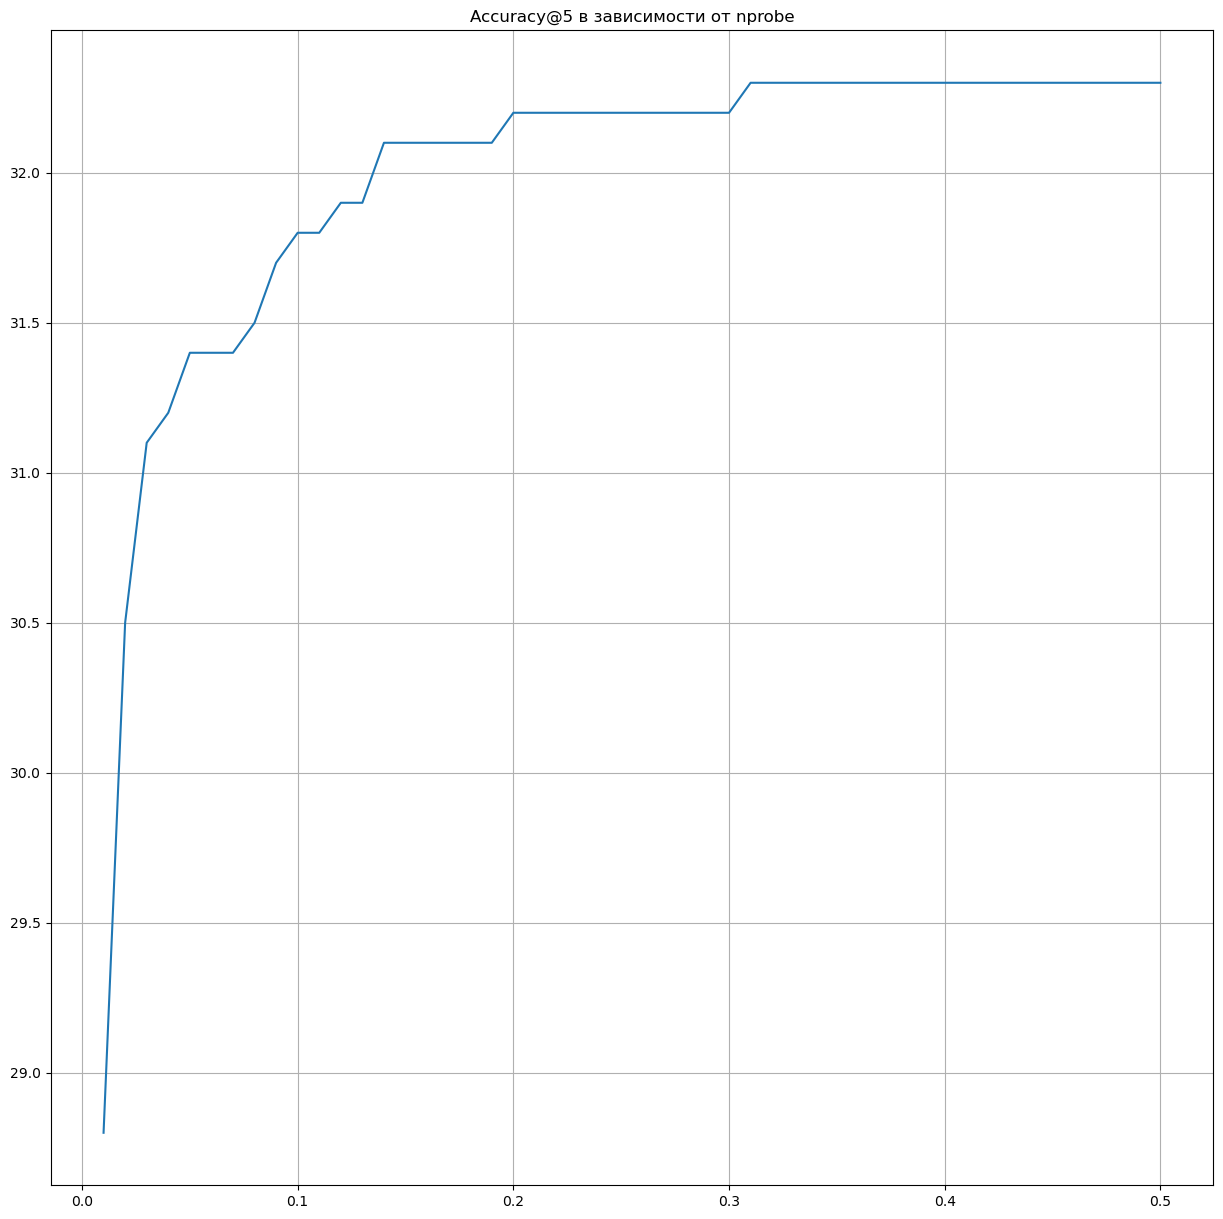

In [52]:
plt.subplot()
plt.plot(m_list, acc_val)
plt.title('Accuracy@5 в зависимости от nprobe')
plt.grid()

На графике можно выделить два характерных излома:

1) nprobe = 5-6% от количества кластеров

2) nprobe= 15% от количества кластеров 

Более высокие значения nprobe перебирать смысла нет, потому что это увеличивает длительность поиска решения

В целом если нужна более высокая скорость, то nprobe можно взять равным 0.05 * n_cell, если чуть повыше точность, то nprobe = 0.15 * n_cell

#### Совместное влияние nprobe и n_cell

Теперь проверим совместное влияние nprobe и n_cell и найдем оптимальные настройки для модели:

выберем n_cell в диапазоне [100, 800] с шагом 50
и nprobe в диапазоне от 5 до 17 с шагом 3

Перебирая параметры посмотрим как изменяется точность при варьировании двух параметров

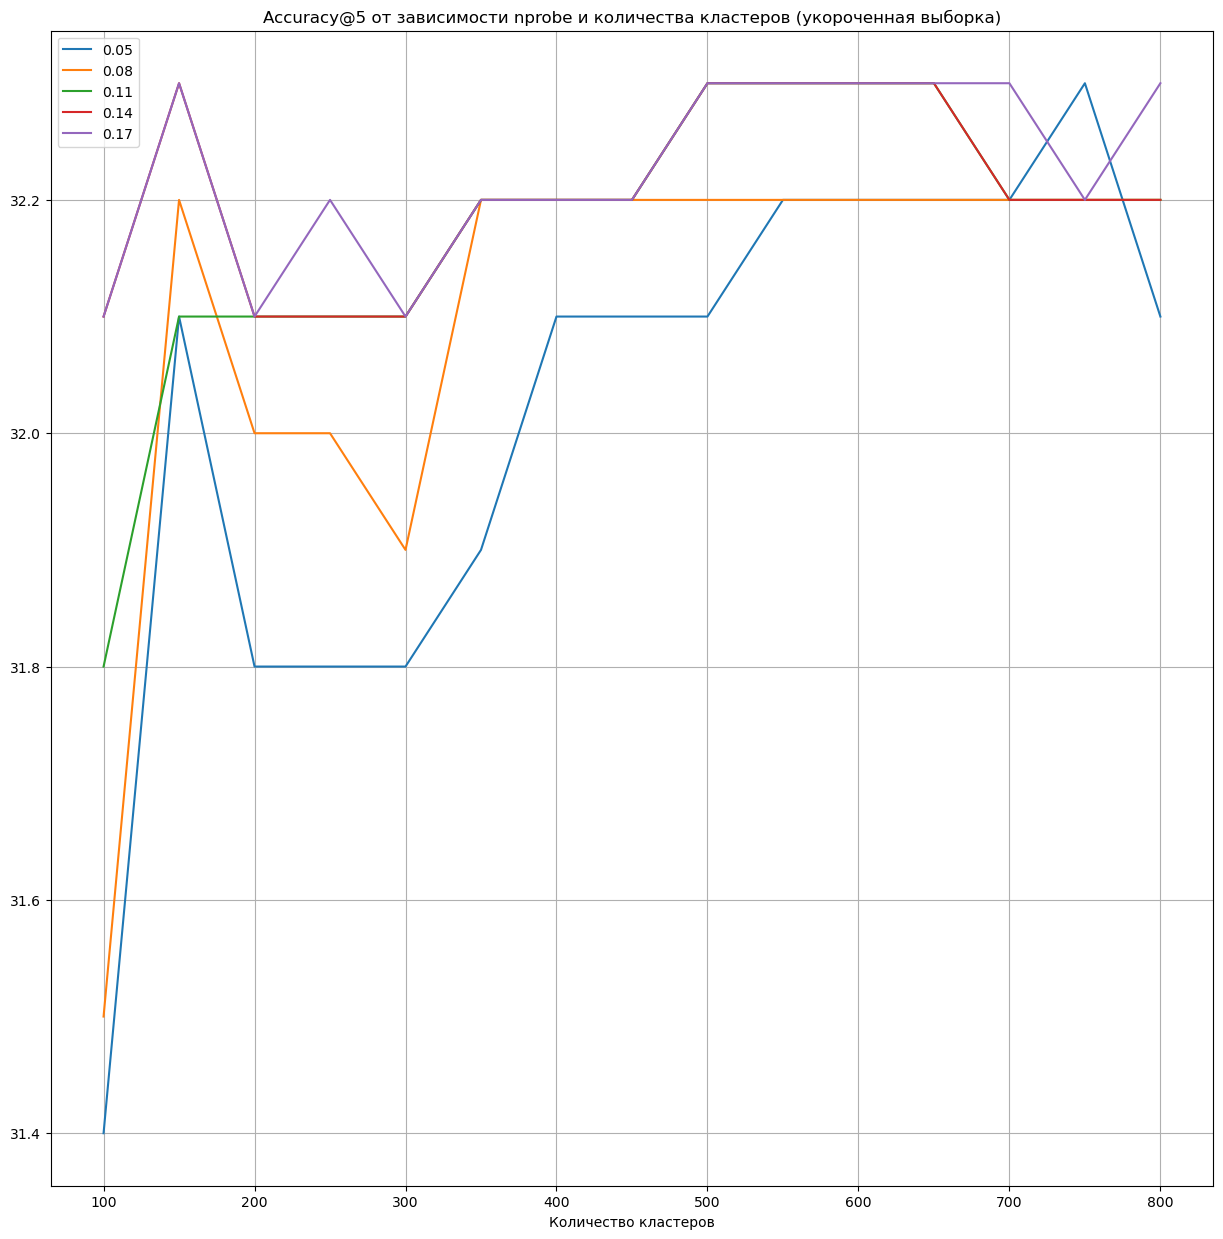

CPU times: user 27min 56s, sys: 3min 3s, total: 30min 59s
Wall time: 4min 25s


In [53]:
%%time


dims = data_base_scaled.shape[1]

n_cell_list = list(range(100,801,50))
m_list = (np.array(range(5, 18, 3)) / 100).tolist()
for m in m_list:
    acc_val = []
    for n_cell in n_cell_list:
    
        quantizer = faiss.IndexFlatL2(dims)

        idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cell)
     
        idx_l2.nprobe = int(n_cell * m)

        idx_l2.train(np.ascontiguousarray(data_base_scaled.values[:50000, :]).astype('float32'))
        idx_l2.add(np.ascontiguousarray(data_base_scaled.values[:500000, :]).astype('float32'))

        base_index = {k: v for k, v in enumerate(data_base_scaled.index.to_list())}

        top_count = 5

        vectors_train_5, idx_train_5 = idx_l2.search(np.ascontiguousarray(train_features_scaled.values[:1000, :]).astype('float32'), top_count)

        vectors_valid_5, idx_valid_5 = idx_l2.search(np.ascontiguousarray(data_validation_scaled.values[:1000, :]).astype('float32'), top_count)

        acc_train = 0
        for target, candidates in zip(train_target.values.tolist(), idx_train_5.tolist()):
            acc_train += int(target in [base_index[number] for number in candidates])

        acc_valid = 0
        for target, candidates in zip(validation_answer['Expected'].values.tolist(), idx_valid_5.tolist()):
            acc_valid += int(target in [base_index[number] for number in candidates])

        acc_val.append((acc_valid / len(idx_valid_5) * 100))

    plt.subplot()
    plt.plot(n_cell_list, acc_val)
plt.grid()    
plt.legend(m_list)
plt.title('Accuracy@5 от зависимости nprobe и количества кластеров (укороченная выборка)')
plt.xlabel('Количество кластеров')
plt.show()

    #     print('n_cell = ', n_cell)
    #     print('probe =', idx_l2.nprobe)
    #     print('accuracy train : {}%'.format(acc_train / len(idx_train_5) * 100))
    #     print('accuracy valid : {}%'.format(acc_valid / len(idx_valid_5) * 100))
    #     print()

    

Легенда на графике показывает какую доля nprobe составляет от n_cell

По графику совокупного влияния nprobe и n_cell видно, что лучшая метрика на укороченной выборке получается при 600-700 кластерах метрака при любых nprobe получается довольно высокой. Да, если n_probe больше, то метрика чуть выше, но разница в 0.2%.  если нужно ускорить расчеты, то целесообразно выбирать именно такое количество кластеров и такое количество n_probe.

Стоить отметить, что качество метрики при 600-800 кластерах оказалась таким же, как и при 100, однако качемвто метрики при 600-800 кластерах в меньшей степени зависит от n_probe. 

### Итоговый расчет метрики на полных датасетах

Для расчета итоговой метрики на всем датасете возьмем 600 кластеров. А nprobe, равной 0.05 от количества кластеров. Таким образом:

1) n_cell = 600

2) nprobe = 0.05 * n_cell = 30

In [54]:
%%time


dims = data_base_scaled.shape[1]
n_cell = 600

quantizer = faiss.IndexFlatL2(dims)

idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cell)

idx_l2.nprobe = int(n_cell * 0.05)

idx_l2.train(np.ascontiguousarray(data_base_scaled.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(data_base_scaled.values).astype('float32'))

base_index = {k: v for k, v in enumerate(data_base_scaled.index.to_list())}

top_count = 5

vectors_train_5, idx_train_5 = idx_l2.search(np.ascontiguousarray(train_features_scaled.values).astype('float32'), top_count)

vectors_valid_5, idx_valid_5 = idx_l2.search(np.ascontiguousarray(data_validation_scaled.values).astype('float32'), top_count)

acc_train = 0
for target, candidates in zip(train_target.values.tolist(), idx_train_5.tolist()):
    acc_train += int(target in [base_index[number] for number in candidates])

acc_valid = 0
for target, candidates in zip(validation_answer['Expected'].values.tolist(), idx_valid_5.tolist()):
    acc_valid += int(target in [base_index[number] for number in candidates])

print('probe =', idx_l2.nprobe)
print('accuracy train : {}%'.format(acc_train / len(idx_train_5) * 100))
print('accuracy valid : {}%'.format(acc_valid / len(idx_valid_5) * 100))
print()

probe = 30
accuracy train : 70.50999999999999%
accuracy valid : 70.429%

CPU times: user 17min 35s, sys: 17.9 s, total: 17min 53s
Wall time: 2min 48s


В итоге метрика accuracy@5 на тренировочном датасете составила 70.51%, а на валидационном - 70.43%

Повысить метрику можно, снижая n_cell, например, до 50, но это сильно увеличит время расчетов. Также можно повышать метрику за счет nprobe, но также увеличивает длительность расчетов. 

При выбранных параметрах длительность расчета метрики составила 2 минуты 41 секунду

Отдельно отмечу, что прогонял отдельно эту модель с nprobe = 15 и n_cell = 100. Расчет занял почти 13 минут. А значение метрики было 70.8 % и 70.6% на тренировочной и валидационной выборках. Поэтому смысла идти в сторону уменьшения количества кластеров нет

## ANNOY

Решим эту же задачу с помощью библиотеки ANNOY

В контексте данной задачи решение очень похоже на решение в FAISS

Изменяемыми параметрами здесь являются количество деревьев `n_trees` и метрика расчета. Метрики следующие: "angular", "euclidean", "manhattan", "hamming" и "dot". То есть по сути это методы расчета расстояния между векторами

Отдельно скажу, что прогонял все метрики отдельно с разным количеством деревьев. Наиболее близкий результат к FAISS дало эвклидово расстояние с количеством решающих деревьев 250. 

При стандартном количестве дерьев `n_trees` (это всего 10) значение метрики было около 57%, при 100 - 67%, а при 250 деревьях - 70.109 % на тренировочной выборке при длительности расчета около 6 минут. Увеличение количества дереьвев приводит к заметному повышению времени выполнения кода, и при 500 деревьях за час результат не был получен. 

Другие метрики дали результат хуже либо при том же времени расчета, либо при более заметно более длительном, как например 'angular', где при 50 деревьях время расчета составило около часа, а точность была 60%. 

Отдельно каждый параметр я в код не выносил, оставил только финальный результат

In [55]:
%%time
# Создадим размерность пространства индекса (длина вектора)
dims = data_base_scaled.shape[1]

n_trees = 250 
index = AnnoyIndex(dims, 'euclidean')

for i in range(data_base_scaled.shape[0]):
    vector = data_base_scaled.values[i]
    index.add_item(i, vector)
    
index.build(n_trees, n_jobs=-1)

# создаем индексы из BASE
base_index = {k: v for k, v in enumerate(data_base_scaled.index.to_list())}

# количество ближайших соседей
top_count = 5

# Поиск индексов ближайших соседей в тренировочной и валидационной выборках
idx_train_5 = [index.get_nns_by_vector(vector, top_count) for vector in train_features_scaled.values.tolist()]

idx_valid_5 = [index.get_nns_by_vector(vector, top_count) for vector in data_validation_scaled.values.tolist()]

# Расчет метрики accuracy@5
acc_train = 0
for target, candidates in zip(train_target.values.tolist(), idx_train_5):
    acc_train += int(target in [base_index[number] for number in candidates])

acc_valid = 0
for target, candidates in zip(validation_answer['Expected'].values.tolist(), idx_valid_5):
    acc_valid += int(target in [base_index[number] for number in candidates])

print('accuracy train : {}%'.format(acc_train / len(idx_train_5) * 100))
print('accuracy valid : {}%'.format(acc_valid / len(idx_valid_5) * 100))
print()

accuracy train : 70.109%
accuracy valid : 69.963%

CPU times: user 30min 47s, sys: 42.2 s, total: 31min 29s
Wall time: 6min 25s


## Вывод по работе

Задача мэтчинга была решениа с использованием библиотек FAISS и ANNOY

**FAISS:**

Были проанализированы данные. Установлено, что 8 признаков из 72 имеют отличное от нормального распределение. Мы их в итоге выбросили из модели

Были опробованы разные скейлеры (standard, minmax, robust (c PowerTransformer с ходу не вышло)). Был выбран standard scaler.

Далее на уменьшенных выборках (500000 base, и по 1000 train и valid) было определено влияние количества кластеров и nprobe на метрику. 

Установлено, что начиная с количества кластеров (n_cell) более 150 на малой выборке влияние на метрику практически отсутствует (тем не менее есть заметные колебания значения метрики).

Увеличение nprobe (или количество соседних опрашиваемых кластеров) дает почти непрерывный прирост к метрике. Однако негативно сказывается на времени вычисления, что в целом логично. На графике влияния nprobe на метрику видно, что скорость роста метрики меняется при nprobe = 0.05 % и 0.15% от количества кластеров (n_cells)

Оценка совокупного влияния n_cell и nprobe показала, что на уменьшенной выборке метрика падает в диапазоне от 200 до 300 кластеров вне зависимости от nprobe. А при большем количестве кластеров (600-800) метрика в меньшей степени зависит от nprobe. 

В связи с этим для оценки метрики на полной выборке были выбраны `n_cell = 600` и `nprobe = 0.05 * n_cell = 30`
Метрика accuracy@5 показала резльтат 70.51% и 70.43% на тренировочной и валидационной выборках соответственно 

Уменьшение n_cell, ровно как и увеличение nprobe может привести к улучшению результата, но длительность расчетов может увеличиться в разы, а метрика при этом может вырасти на 0.5%, что в рамках данной задачи мне видится нецелесообразным. (отдельно была проверена модель с nprobe = 15 и n_cell = 100, расчет занял в 6 раз больше времени, а метрика выросла на с 70.5% до 70.8%). 

**ANNOY**

Также было найдено решение с помощью библиотеки `ANNOY`. При выборе метрики 'euclidean' и количестве 'n_trees = 250' результат accuracy@5 получился близким к решению в FAISS. Значение метрики accuracy@5 составило 70,1% для тренировочной выборки. 